<a href="https://colab.research.google.com/github/cl6530/DL_final_project/blob/main/training_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/env.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils_wp.py
!wget https://raw.githubusercontent.com/cl6530/DL_final_project/main/dueling.py

--2023-05-05 21:06:36--  https://raw.githubusercontent.com/cl6530/DL_final_project/main/env.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4453 (4.3K) [text/plain]
Saving to: ‘env.py’

env.py              100%[===================>]   4.35K  --.-KB/s    in 0s      

2023-05-05 21:06:37 (59.9 MB/s) - ‘env.py’ saved [4453/4453]

--2023-05-05 21:06:37--  https://raw.githubusercontent.com/cl6530/DL_final_project/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3669 (3.6K) [text/plain]
Saving to: ‘utils.py’

utils.py   

# ENV

In [2]:
from env import StockTradingEnv
from utils import select_action,Transition,ReplayMemory, get_data #optimize_model
from utils_wp import optimize_model
from dueling import DuelingDQN
from google.colab import drive
import torch
import torch.nn as nn
import random
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Get Data

In [3]:
drive.mount('/content/drive')
path = r'/content/drive/My Drive/Colab Notebooks/dataset'
data = get_data(drive_path = path)

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive
['/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2021.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2022.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2019.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2017.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2020.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2015.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2014.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2013.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2016.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2012.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2023.csv', '/content/drive/My Drive/Colab Notebooks/dataset/EminiSP500future_2011.csv', '/content/drive/My Drive/Colab Notebooks/dataset/

# Models

In [4]:
EPS = 1
N_EXPLORATION = 20
TAU = 0.1
LR = 1e-3
TRANSCATION_COST = 0.0005
INIT_PORT = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
policy_net = DuelingDQN(2, 3).to(device)
target_net = DuelingDQN(2, 3).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [6]:
def eval_model(policy):
    '''
    evaluate the model using test data (last 500 data points)
    and record the percentage of each action (long, short or stay)
    '''

    NAV = [1000]
    BAH = [1000]
    returns = data.values[-500:]
    env = StockTradingEnv(returns,TRANSCATION_COST,INIT_PORT)
    t = 5
    done = False
    actions = []
    while not done:
      state = env.current_state
      action = select_action(state,0,env.action_space,policy,device)
      actions.append(action.cpu())
      state, action,reward,next_state, done = env.step(action.item())
      NAV.append(NAV[-1]*(1+reward))
      BAH.append(BAH[-1]*(1+returns[t]))
      t+=1
    plt.plot(NAV, label = 'NAV')
    plt.plot(BAH, label = 'BAH')
    plt.legend()
    plt.show()
    plt.scatter(np.arange(0,len(actions)),actions,s=0.1)
    plt.show()

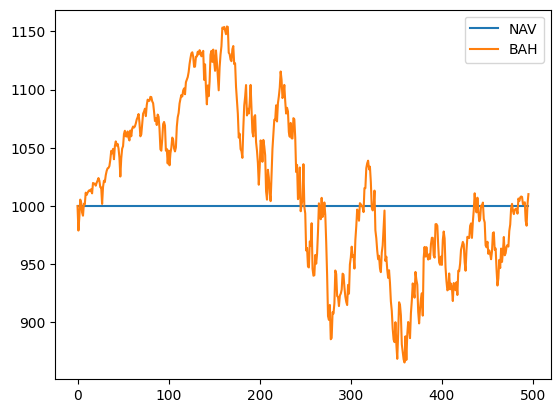

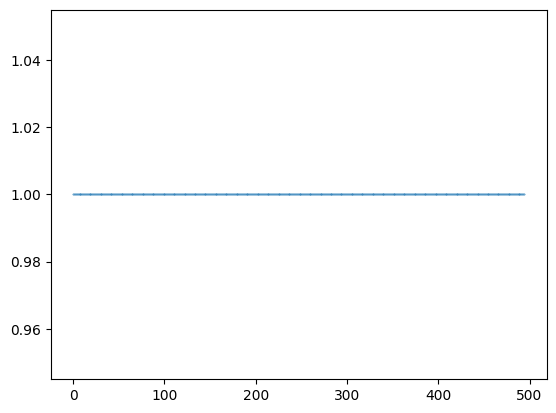

In [7]:
eval_model(target_net)

# Train

In [9]:
criterion = nn.MSELoss()

0.9996031746031746


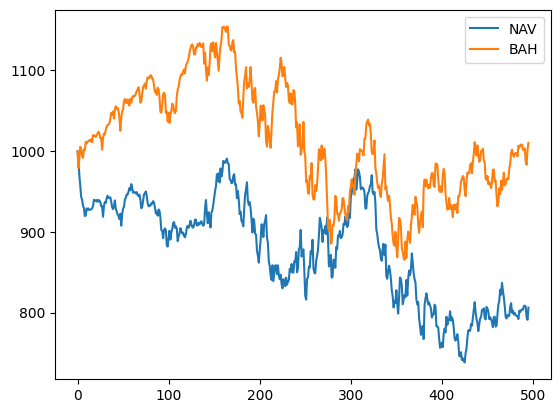

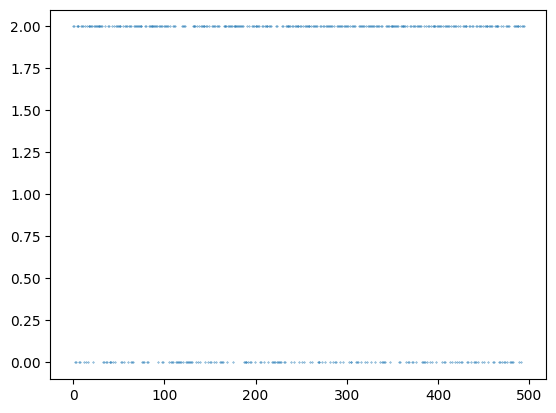

0.9496031746031748
0.899603174603175
0.8496031746031751
0.7996031746031753
0.7496031746031755
0.6996031746031757
0.6496031746031758
0.599603174603176
0.5496031746031762
0.4996031746031764


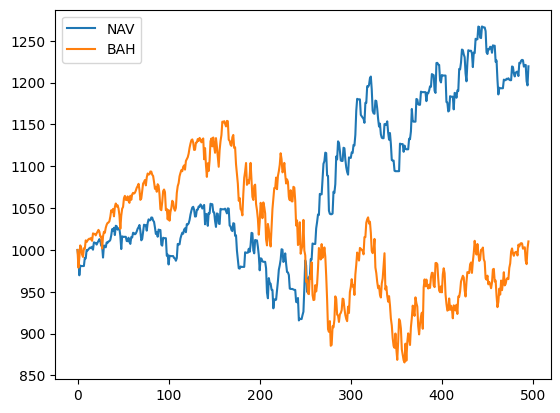

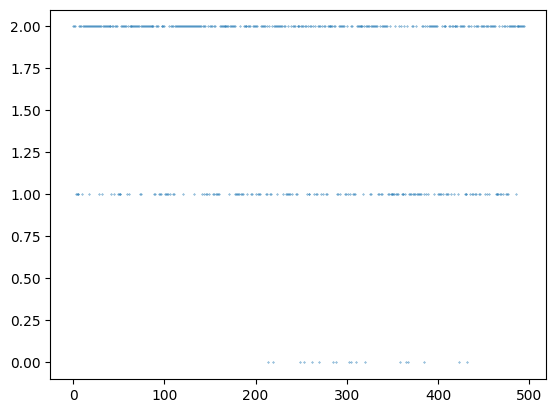

0.44960317460317656
0.39960317460317674
0.3496031746031769
0.2996031746031771
0.24960317460317727
0.19960317460317745
0.14960317460317762
0.0996031746031778
0.04960317460317798
0


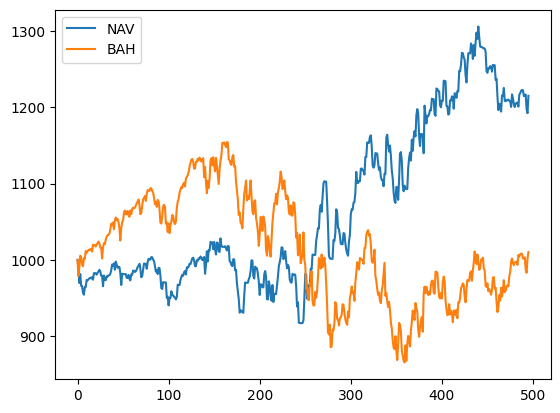

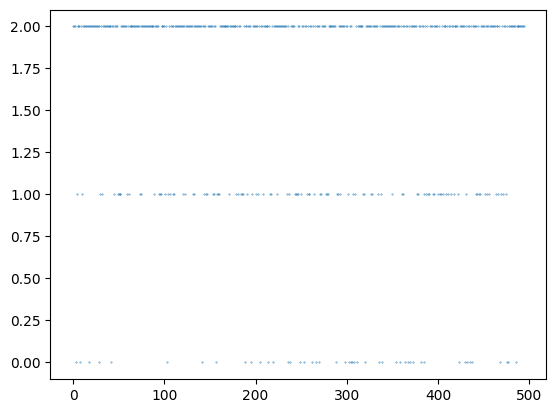

0
0
0
0
0
0
0
0
0
0


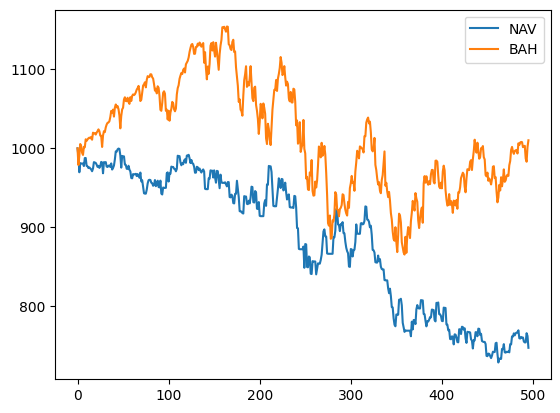

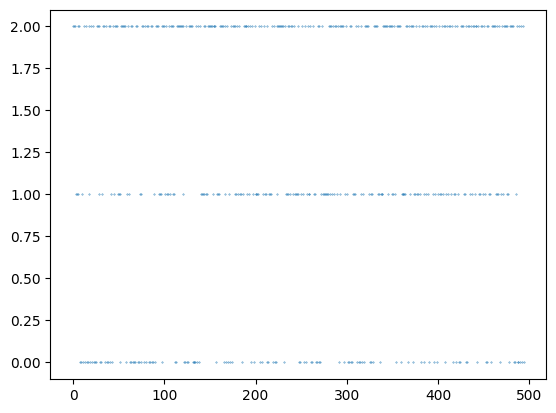

0
0
0
0
0
0
0
0
0
0


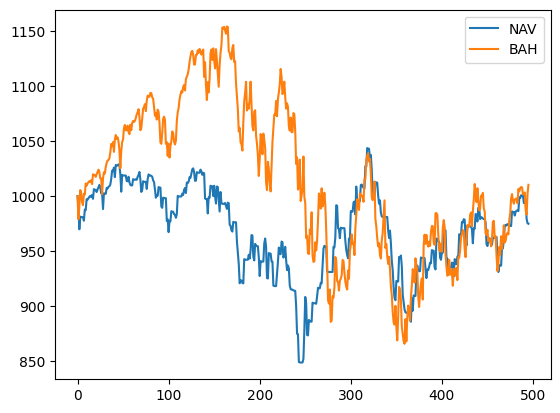

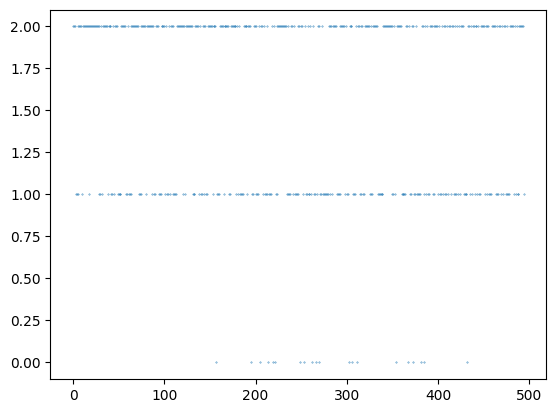

0
0
0
0
0
0
0
0
0
0


In [ ]:
memory = ReplayMemory(100000)

if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 50

for i_episode in range(num_episodes):

    # get 252 returns
    # since step start at 5, we extract 257 returns
    start = random.randint(0,len(data-500)-257)
    stock_returns = data.values[start:start + 257]

    #creat an env
    env = StockTradingEnv(stock_returns,TRANSCATION_COST,INIT_PORT)
    done = False
    print(EPS)
    while not done:    
      #linear epsilon decay in the first n_exploration episodes, then exploit
      EPS = max(0,EPS-1/(252*N_EXPLORATION))
      
      state = env.current_state

      #get action
      action = select_action(state,EPS,env.action_space,policy_net,device)

      #step
      state, action,reward,next_state, done = env.step(action.item())

      #store in replay
      memory.push(torch.tensor(state.astype(np.float32),device=device), torch.tensor([action],device=device), torch.tensor(next_state.astype(np.float32),device=device), torch.tensor(reward,device=device))

      #optimize
      if len(memory) < 2:
          continue
      optimize_model(memory,optimizer,policy_net,target_net,device,criterion,-0.01,1)

      # FIXME: Current Verision using soft update, the paper uses hard updates every 100 step
      target_net_state_dict = target_net.state_dict()
      policy_net_state_dict = policy_net.state_dict()
      for key in policy_net_state_dict:
          target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
      target_net.load_state_dict(target_net_state_dict)
    if i_episode%10 == 0:
      eval_model(target_net)
eval_model(target_net)